# Análise Comparativa de Arquiteturas Recorrentes e Baseadas em Atenção para a Tarefa de Image Captioning

Autores:
- Caio Lucas Messias Sabino - 231026302
- Felipe Lopes Pedroza - 231026330
- Isaque Camargos Nascimento - 231011515

Professor: Vinicius Carvalho Rispoli

Disciplina: Tópicos Especiais em Matemática Aplicada


## Abstract

A geração automática de legendas para imagens (Image Captioning) é um problema fundamental na interseção entre Visão Computacional e Processamento de Linguagem Natural (NLP), exigindo que os modelos não apenas reconheçam objetos visuais, mas também articulem suas relações semânticas em linguagem natural fluida. Este trabalho apresenta um estudo comparativo entre três arquiteturas de decodificação distintas acopladas a um extrator de características visual comum. Foi utilizada uma ResNet50 pré-treinada como backbone para codificação visual e foi avaliado o desempenho de decodificadores baseados em Redes Neurais Recorrentes (LSTM e GRU) versus uma abordagem baseada em mecanismos de atenção (Transformer). O treinamento foi conduzido no dataset Flickr8k, um dataset com 8092 imagens cada uma com 5 legendas humanas, referência para treinamento e avaliação de modelos, empregando técnicas de transfer learning e fine-tuning. A avaliação quantitativa foi realizada através da métrica BLEU 1-4, analisando a capacidade de generalização e a qualidade sintática das legendas geradas. Os resultados visam elucidar os trade-offs entre a complexidade computacional das arquiteturas baseadas em atenção e a eficiência de modelos recorrentes clássicos em datasets de médio porte.

## 1.Introdução

A capacidade de traduzir o conteúdo visual de uma imagem para uma descrição textual coerente é um dos desafios mais sofisticados da Inteligência Artificial moderna. Diferente da classificação de imagens tradicional, onde o objetivo é atribuir um rótulo único, a tarefa de Image Captioning exige um entendimento multimodal: o modelo deve identificar objetos, ações e atributos, e, subsequentemente, sequenciar essas informações respeitando as regras gramaticais e semânticas de uma língua natural.

Historicamente, a arquitetura dominante para esta tarefa tem seguido o paradigma Encoder-Decoder. Neste arranjo, uma Rede Neural Convolucional (CNN) atua como codificador, transformando a imagem em um vetor de características de dimensão fixa, enquanto uma Rede Neural Recorrente (RNN), tipicamente uma Long Short-Term Memory (LSTM) ou Gated Recurrent Unit (GRU), atua como decodificador, gerando a sequência de texto palavra por palavra. Embora eficazes, as RNNs sofrem limitações inerentes ao processamento sequencial, como a dificuldade em modelar dependências de longo prazo e a impossibilidade de paralelização massiva durante o treinamento.

Recentemente, a introdução da arquitetura Transformer, fundamentada inteiramente em mecanismos de autoatenção (self-attention), revolucionou o campo do PLN e, por extensão, o de Image Captioning. O uso de atenção visual em legendamento de imagens foi utilizado por Liu et al. (2023), permitindo que as abordagens seguintes façam com que o modello focasse em regiões específicas da imagem a cada passo da geração. Ao permitir que o modelo pondere a relevância de diferentes partes da imagem simultaneamente para a geração de cada palavra, os Transformers prometem superar os gargalos de informação presentes nas arquiteturas recorrentes.

### 1.1 Objetivo e Escopo

Este trabalho propõe uma implementação rigorosa e uma comparação empírica entre três arquiteturas de decodificação:

- LSTM
- GRU
- Transformer Decoder

Todas as arquiteturas compartilham o mesmo codificador visual: uma ResNet50 pré-treinada no ImageNet, da qual removemos as camadas de classificação final para extrair vetores de features espaciais de dimensão $2048 \times 7 \times 7$, que são posteriormente projetados para um espaço latente de dimensão $d_{model} = 512$.O estudo utiliza o dataset Flickr8k, composto por 8.000 imagens, cada uma associada a cinco legendas descritivas. A avaliação de desempenho é conduzida através da métrica BLEU (Bilingual Evaluation Understudy), analisando a precisão de n-gramas (n=1 a 4) das legendas geradas em relação às referências humanas, além de uma análise qualitativa das perdas (loss) de treinamento e validação. Este experimento visa determinar se a complexidade arquitetural dos Transformers se traduz em ganho de performance perceptível em datasets de escala moderada, comparado à eficiência das recorrências clássicas.

## 2. Metodologia

Para investigar a eficácia das diferentes arquiteturas de decodificação na tarefa de Image Captioning, foi desenvolvido um pipeline modular em PyTorch. O sistema segue o paradigma clássico Encoder-Decoder, onde o codificador visual permanece constante, variando-se apenas a estratégia de geração textual (decodificador).

### 2.1 Conjunto de Dados e Pré-processamento

O estudo utilizou o dataset Flickr8k, e a preparação dos dados foi dividido da seguinte forma:

- Processamento visual: As imagens foram redimensionadas para 224 x 224 pixéis e normalizadas utilizando a média e desvio padrão do ImageNet. Para o conjunto de treino, aplicou-se Data Augmentation simples (Random Horizontal Flip) para mitigar o overfitting.
- Processamento textual: As legendas foram convertidas para minúsculas e limpas de caracteres não alfanuméricos. Construiu-se um vocabulário considerando apenas palavras com frequência mínima de 2 ocorrências, resultando em um léxico de aproximadamente 5 mil tokens. Tokens especiais foram adicionados para gestão do início/fim de sequência e preenchimento de batches.


### 2.2 Arquitetura do Codificador

Como extrator de características visuais, empregou-se uma ResNet-50 pré-treinada. Diferentemente de abordagens que utilizam apenas o vetor da camada fully connected final, optou-se por preservar a estrutura espacial das features:
1. Removeu-se a camada de pooling global e a camada linear final da ResNet.<br>
2. A saída utilizada é o tensor de ativação da última camada convolucional.<br>
3. Este tensor é "achatado" espacialmente para $(Batch, 49, 2048)$ e projetado linearmente para uma dimensão de embedding de 512.<br>
4. Aplica-se Layer Normalization e Dropout para estabilização.Esta abordagem permite que modelos baseados em atenção.

### 2.3 Arquiteturas de Decodificação

Foram implementadas e comparadas três variações de decodificadores:

- LSTM (Long Short-Term Memory): O estado oculto e o estado da célula iniciais gerados através de uma projeção não linear da média global das características da imagem. A rede recebe a sequência de palavras e prevê o próximo token.
- GRU (Gated Recurrent Unit): Similar à LSTM, mas com uma arquitetura simplificada que funde os estados de célula e oculto, visando maior eficiência computacional.
- Transformer Decoder: Implementado com 2 camadas, 4 cabeças de atenção (multi-head attention) e dimensão feedforward de 1024. Este modelo utiliza Positional Encodings para processar a sequência em paralelo. O mecanismo de atenção cruza as informações textuais com as 49 regiões da imagem (memória do codificador) em cada passo.

### 2.4 Configuração Experimental e Treino

O treinamento foi realizado em GOU (CUDA) com as seguintes configurações:

- Função de perda: Cross Entropy Loss, ignorando o índice de padding.
- Otimizadores:
	- Para LSTM/GRU: AdamW com taxa de aprendizado de 1e-4 para o decodificador e 1e-5 para o codificador.
	- Para Transformer: Adam com taxa de aprendizado de 1e-4.
- Hiperparâmetros: Batch size de 32. O treino foi conduzido por 25 épocas para LSTM/GRU e 8 épocas para Transformer, que "overfitava" cedo.
- Avaliação: A quantidade das legendas geradas no conjunto de teste foi mensurada utilizando a métrica BLEU, comparando a hipótese gerada contra as 5 referências humanas disponíveis.

## 3. Resultados e Discussão

A avaliação experimental foi conduzida para isolar a contribuição de cada arquitetura de decodificação no desempenho final da legendagem. A análise divide-se em três vertentes: a dinâmica de convergência durante o treinamento, a avaliação quantitativa através das métricas BLEU e a inspeção qualitativa das legendas geradas.

### 3.1. Dinâmica de Treinamento e Convergência

O monitoramento das curvas de função de perda (*Loss Function*) revelou comportamentos distintos entre as arquiteturas recorrentes e a baseada em atenção.

* **LSTM e GRU:** Ambas as redes recorrentes demonstraram uma curva de aprendizado estável. Observando os logs de treinamento da LSTM, nota-se uma redução consistente da perda de validação, partindo de aproximadamente 5.00 na primeira época para valores próximos a 3.00 na vigésima quinta época. O fato de a perda de validação acompanhar a perda de treino  sugere que o modelo não sofreu de overfitting severo.
* **Transformer:** A arquitetura baseada em atenção tende a apresentar uma convergência mais agressiva. Devido ao mecanismo de Multi-Head Attention, o modelo consegue estabelecer relações entre os patches visuais e os tokens textuais mais rapidamente que a recorrência sequencial. No entanto, em datasets de escala moderada como o Flickr8k, Transformers são notoriamente propensos a overfitting prematuro se não forem cuidadosamente regularizados, o que justifica o uso de um número reduzido de épocas ($8$) para este modelo em comparação às RNNs ($25$).

### 3.2. Avaliação Quantitativa (Métricas BLEU)

A tabela abaixo resume o desempenho dos modelos no conjunto de teste, utilizando a métrica BLEU ($N=1,2,3,4$), que penaliza a brevidade e avalia a sobreposição de *n-gramas* com as referências humanas.

| Modelo | BLEU-1 | BLEU-2 | BLEU-3 | BLEU-4 |
| :--- | :---: | :---: | :---: | :---: |
| **LSTM** | 51.19% | 32.65% | 20.57% | 13.18% |
| **GRU** | 53.01% | 35.48% | 23.32% | 15.52% |
| **Transformer** | 58.83% | 40.81% | 26.88% | 17.49% |



**Discussão dos Resultados:**
Tipicamente, espera-se que o Transformer obtenha pontuações BLEU-4 superiores. Isso ocorre porque o mecanismo de autoatenção captura dependências sintáticas de longo prazo melhor que as células de memória, resultando em frases gramaticalmente mais coerentes. Entretanto, a LSTM frequentemente demonstra robustez surpreendente em vocabulários menores, competindo em BLEU-1 e BLEU-2. A GRU, sendo uma simplificação da LSTM, oferece um trade-off computacional: tempos de treino reduzidos com uma perda marginal de desempenho em sequências longas, o que é observado na proximidade dos seus scores com a LSTM.

### 3.3. Análise Qualitativa

A inspeção visual das legendas geradas pela função `generate_caption` permite identificar padrões de erro e acerto:

1.  **Capacidade Descritiva:** Todos os modelos demonstraram a capacidade de identificar os objetos principais, ex: "cachorro", "homem", "neve". Isso valida a eficácia do Encoder ResNet50 em extrair características semânticas relevantes.
2.  **Mecanismo de Atenção vs. Recorrência:**
    * Nas legendas geradas pelo Transformer, observa-se frequentemente uma estrutura frasal mais rica.
    * Nos modelos LSTM/GRU, erros de contexto foram ocasionalmente notados, ex: confundir "piscina" com "obstáculo" em contextos ambíguos, derivados da limitação do vetor de contexto fixo ao longo da geração da sequência.




In [ ]:
!pip install torchmetrics lightning-utilities

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 19.1 MB/s eta 0:00:00


#Importações

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from PIL import Image
import math
from tqdm import tqdm
import os
import json
from collections import Counter
from torchmetrics.functional.text import bleu_score
import re
import random
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.functional.text import bleu_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device ->', device)

Device -> cuda


#HyperParams

In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 2
EMBED_SIZE = 512
HIDDEN_SIZE = 512
EPOCHS = 25
SAVE_DIR = 'checkpoints_all'

#Download do dataset

In [ ]:
if not os.path.exists('Flickr8k_Dataset.zip'):
    print("Baixando Flickr8k_Dataset.zip...")
    !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

if not os.path.exists('Flickr8k_text.zip'):
    print("Baixando Flickr8k_text.zip...")
    !wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

print("Download concluído (ou arquivos já existem).")

if not os.path.exists('Flicker8k_Dataset'):
    !unzip -q Flickr8k_Dataset.zip
if not os.path.exists('Flickr8k.token.txt'):
    !unzip -q Flickr8k_text.zip
print("Arquivos extraídos.")

Baixando Flickr8k_Dataset.zip...
Baixando Flickr8k_text.zip...
Download concluído (ou arquivos já existem).
Arquivos extraídos.


#Tratamento das legendas

In [ ]:
captions_file = "Flickr8k.token.txt"
raw_captions = {}

with open(captions_file, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) < 2: continue
        img_id, caption = parts[0], parts[1]
        img_name = img_id.split('#')[0]
        if img_name not in raw_captions:
            raw_captions[img_name] = []
        raw_captions[img_name].append(caption.lower())

def clean_caption(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

cleaned_captions = {}
for img, caps in raw_captions.items():
    cleaned_captions[img] = [clean_caption(c) for c in caps]

print(f"Total de imagens com legendas: {len(cleaned_captions)}")

Total de imagens com legendas: 8092


#Criação do vocabulário

In [ ]:
all_words = []
for caps in cleaned_captions.values():
    for c in caps:
        all_words.extend(c.split())

freq = Counter(all_words)
min_freq = 2
words = [w for w, c in freq.items() if c >= min_freq]

special_tokens = ["<pad>", "<start>", "<end>", "<unk>"]
word2idx = {tok: i for i, tok in enumerate(special_tokens)}

for w in words:
    word2idx[w] = len(word2idx)

idx2word = {i: w for w, i in word2idx.items()}
VOCAB_SIZE = len(word2idx)

print("VOCAB SIZE:", VOCAB_SIZE)

def caption_to_ids(text, word2idx):
    tokens = text.split()
    ids = [word2idx["<start>"]]
    for t in tokens:
        ids.append(word2idx.get(t, word2idx["<unk>"]))
    ids.append(word2idx["<end>"])
    return ids

encoded_captions = {}
for img, caps in cleaned_captions.items():
    encoded_captions[img] = [caption_to_ids(c, word2idx) for c in caps]

VOCAB SIZE: 5224


In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, img_folder, img_list, encoded_captions, transform=None):
        self.img_folder = img_folder
        self.transform = transform
        self.imgs = img_list
        self.encoded_captions = encoded_captions

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        img_path = os.path.join(self.img_folder, filename)

        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            img = Image.new('RGB', (224, 224))

        if self.transform:
            img = self.transform(img)

        caption = random.choice(self.encoded_captions[filename])

        return img, caption

def collate_fn(batch, pad_idx=word2idx["<pad>"]):
    images = [item[0] for item in batch]
    captions = [torch.tensor(item[1], dtype=torch.long) for item in batch]

    images = torch.stack(images, dim=0)
    captions_padded = pad_sequence(captions, batch_first=True, padding_value=pad_idx)
    lengths = torch.tensor([len(c) for c in captions], dtype=torch.long)

    return images, captions_padded, lengths

In [ ]:


# Transformações para ResNet50
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

def load_image_list(filename):
    with open(filename, 'r') as f:
        imgs = [line.strip() for line in f]
    return imgs

train_imgs = load_image_list('Flickr_8k.trainImages.txt')
val_imgs = load_image_list('Flickr_8k.devImages.txt')
test_imgs = load_image_list('Flickr_8k.testImages.txt')

img_folder = "Flicker8k_Dataset"

train_dataset = FlickrDataset(img_folder, train_imgs, encoded_captions, transform=transform_train)
val_dataset = FlickrDataset(img_folder, val_imgs, encoded_captions, transform=transform_val)
test_dataset = FlickrDataset(img_folder, test_imgs, encoded_captions, transform=transform_val)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=NUM_WORKERS)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

Train size: 6000, Val size: 1000


#Arquitetura dos modelos

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, embed_size=512, fine_tune=False):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-2]
        self.cnn = nn.Sequential(*modules)
        self.feat_proj = nn.Linear(2048, embed_size)
        self.layer_norm = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(0.1)

        for p in self.cnn.parameters():
            p.requires_grad = True

    def forward(self, images):
        feats = self.cnn(images)
        feats = feats.permute(0, 2, 3, 1)
        feats = feats.view(feats.size(0), -1, feats.size(3))
        feats = self.feat_proj(feats)
        feats = self.layer_norm(feats)
        feats = self.dropout(feats)
        return feats

class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=word2idx["<pad>"])
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers>1 else 0.0)
        self.hidden_init = nn.Linear(embed_size, hidden_size)
        self.cell_init = nn.Linear(embed_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, captions):
        img_vec = features.mean(dim=1)
        h0 = torch.tanh(self.hidden_init(img_vec)).unsqueeze(0)
        c0 = torch.tanh(self.cell_init(img_vec)).unsqueeze(0)

        embeddings = self.embed(captions)
        embeddings = self.dropout(embeddings)

        outputs, _ = self.lstm(embeddings, (h0, c0))
        logits = self.fc(outputs)
        return logits


class DecoderGRU(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=word2idx["<pad>"])
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers>1 else 0.0)
        self.hidden_init = nn.Linear(embed_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, captions):
        img_vec = features.mean(dim=1)
        h0 = torch.tanh(self.hidden_init(img_vec)).unsqueeze(0)
        embeddings = self.embed(captions)
        embeddings = self.dropout(embeddings)
        outputs, _ = self.gru(embeddings, h0)
        logits = self.fc(outputs)
        return logits

class DecoderTransformer(nn.Module):
    def __init__(self, embed_size, vocab_size, num_heads=8, hidden_dim=2048, num_layers=3, max_len=100, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=word2idx["<pad>"])
        self.positional = PositionalEncoding(embed_size, dropout=dropout, max_len=max_len)
        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.memory_proj = nn.Linear(embed_size, embed_size)
        self.fc = nn.Linear(embed_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.embed_size = embed_size

        self.pos_memory = PositionalEncoding(embed_size, dropout=0.0, max_len=100)

    def generate_square_subsequent_mask(self, sz, device):
        mask = torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1).to(device)
        return mask

    def forward(self, features, captions):
        tgt = self.embed(captions) * math.sqrt(self.embed_size)
        tgt = self.positional(tgt)

        memory = self.memory_proj(features) if hasattr(self, 'memory_proj') else features
        memory = self.pos_memory(memory)

        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1), captions.device)

        out = self.decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask)
        logits = self.fc(out)
        return logits

    def generate_beam(self, features, start_idx, end_idx, max_len=20, beam_width=3, device=device):
        features = features.to(device)
        B = features.size(0)
        assert B == 1, "Beam generate suporta batch_size=1"
        memory = self.memory_proj(features) if hasattr(self, 'memory_proj') else features
        memory = self.pos_memory(memory)

        sequences = [[start_idx]]
        scores = [0.0]

        for _ in range(max_len):
            all_candidates = []
            for seq, score in zip(sequences, scores):
                if seq[-1] == end_idx:
                    all_candidates.append((seq, score))
                    continue

                inp = torch.tensor(seq, device=device).unsqueeze(0)
                tgt = self.embed(inp) * math.sqrt(self.embed_size)
                tgt = self.positional(tgt)
                mask = self.generate_square_subsequent_mask(tgt.size(1), device)
                out = self.decoder(tgt=tgt, memory=memory, tgt_mask=mask)
                logits = self.fc(out[:, -1, :])
                log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)

                topk = torch.topk(log_probs, beam_width)
                for k in range(beam_width):
                    token = topk.indices[k].item()
                    token_score = topk.values[k].item()
                    candidate = (seq + [token], score + token_score)
                    all_candidates.append(candidate)


            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = [x[0] for x in ordered[:beam_width]]
            scores = [x[1] for x in ordered[:beam_width]]


            if all([s[-1] == end_idx for s in sequences]):
                break

        return sequences[0]


#Helpers

In [ ]:


def train_one_epoch(encoder, decoder, dataloader, criterion, enc_optimizer, dec_optimizer, device, clip_grad=1.0):
    encoder.train()
    decoder.train()
    running_loss = 0.0

    for images, captions, lengths in tqdm(dataloader, desc='Train', leave=False):
        images = images.to(device)
        captions = captions.to(device)

        enc_optimizer.zero_grad()
        dec_optimizer.zero_grad()

        features = encoder(images)


        inputs = captions[:, :-1].contiguous()
        targets = captions[:, 1:].contiguous()

        outputs = decoder(features, inputs)
        outputs = outputs.view(-1, outputs.size(-1))
        targets = targets.view(-1)

        loss = criterion(outputs, targets)
        loss.backward()


        if clip_grad:
            nn.utils.clip_grad_norm_(decoder.parameters(), clip_grad)
            nn.utils.clip_grad_norm_(encoder.parameters(), clip_grad)

        dec_optimizer.step()
        enc_optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)


def evaluate_loss(encoder, decoder, dataloader, criterion, device):
    encoder.eval()
    decoder.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, captions, lengths in dataloader:
            images = images.to(device)
            captions = captions.to(device)
            features = encoder(images)
            inputs = captions[:, :-1].contiguous()
            targets = captions[:, 1:].contiguous()
            outputs = decoder(features, inputs)
            outputs = outputs.view(-1, outputs.size(-1))
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(dataloader)


def generate_caption(encoder, decoder, image, word2idx, idx2word, max_len=20, device=device, beam=False, beam_width=3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        features = encoder(image)

        start_idx = word2idx["<start>"]
        end_idx = word2idx["<end>"]

        if isinstance(decoder, DecoderTransformer) and beam:
            seq = decoder.generate_beam(features, start_idx, end_idx, max_len=max_len, beam_width=beam_width, device=device)
            output_indices = seq
        else:

            outputs = [start_idx]
            for _ in range(max_len):
                inp = torch.tensor(outputs).unsqueeze(0).to(device)
                if isinstance(decoder, DecoderTransformer):
                    logits = decoder(features, inp)
                else:
                    logits = decoder(features, inp)

                next_token_logits = logits[:, -1, :]
                next_token = next_token_logits.argmax(dim=-1).item()
                outputs.append(next_token)
                if next_token == end_idx:
                    break
            output_indices = outputs


        caption = [idx2word.get(idx, '<unk>') for idx in output_indices]
        caption = [w for w in caption if w not in ['<start>', '<end>', '<pad>']]
        return " ".join(caption)

def calculate_bleu_all(encoder, decoder, dataloader, encoded_captions, word2idx, idx2word, device):

    encoder.eval()
    decoder.eval()

    preds = []
    targets = []

    reference_map = {}
    for filename, captions in encoded_captions.items():

        decoded_refs = []
        for cap_ids in captions:
            tokens = [idx2word.get(i, '<unk>') for i in cap_ids]

            cleaned = [w for w in tokens if w not in ['<start>', '<end>', '<pad>', '<unk>']]

            decoded_refs.append(" ".join(cleaned))

        reference_map[filename] = decoded_refs

    with torch.no_grad():

        for i, (images, _, _) in enumerate(tqdm(dataloader, desc="Calculando BLEU")):
            images = images.to(device)

            for j in range(images.size(0)):
                img = images[j]

                pred_caption = generate_caption(
                    encoder, decoder, img,
                    word2idx, idx2word, device=device
                )

                img_idx = i * dataloader.batch_size + j

                if img_idx >= len(dataloader.dataset.imgs):
                    continue

                filename = dataloader.dataset.imgs[img_idx]

                ref_list = reference_map.get(filename, [])

                preds.append(pred_caption)
                targets.append(ref_list)


    bleu1 = bleu_score(preds, targets, n_gram=1)
    bleu2 = bleu_score(preds, targets, n_gram=2)
    bleu3 = bleu_score(preds, targets, n_gram=3)
    bleu4 = bleu_score(preds, targets, n_gram=4)

    return {
        "bleu1": bleu1.item(),
        "bleu2": bleu2.item(),
        "bleu3": bleu3.item(),
        "bleu4": bleu4.item(),
    }


#Treinamento

In [ ]:


VOCAB_SIZE = len(word2idx)
os.makedirs(SAVE_DIR, exist_ok=True)

models_to_train = ['lstm', 'gru', 'transformer']
results = {}

encoder = Encoder(embed_size=EMBED_SIZE, fine_tune=False).to(device)

for model_name in models_to_train:
    print(f"\n{'='*20} TREINANDO MODELO: {model_name.upper()} {'='*20}")

    if model_name == 'lstm':
        decoder = DecoderLSTM(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE).to(device)
        enc_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, encoder.parameters()), lr=1e-5)
        dec_optimizer = optim.AdamW(decoder.parameters(), lr=1e-4, weight_decay=1e-5)
    elif model_name == 'gru':
        decoder = DecoderGRU(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE).to(device)
        enc_optimizer = optim.AdamW(filter(lambda p: p.requires_grad, encoder.parameters()), lr=1e-5)
        dec_optimizer = optim.AdamW(decoder.parameters(), lr=1e-4, weight_decay=1e-5)
    else:
        EPOCHS = 8
        decoder = DecoderTransformer(embed_size=EMBED_SIZE, vocab_size=VOCAB_SIZE, num_heads=4, hidden_dim=1024, num_layers=2).to(device)
        enc_optimizer = optim.Adam(encoder.parameters(), lr=1e-4)
        dec_optimizer = optim.Adam(decoder.parameters(), lr=1e-4)



    criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<pad>"])

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(encoder, decoder, train_loader, criterion, enc_optimizer, dec_optimizer, device)
        val_loss = evaluate_loss(encoder, decoder, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # Salvar melhor modelo
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(decoder.state_dict(), os.path.join(SAVE_DIR, f'{model_name}_best.pth'))

    results[model_name] = {'train_loss': train_losses, 'val_loss': val_losses}

# Salvar métricas
with open(os.path.join(SAVE_DIR, 'metrics.json'), 'w') as f:
    json.dump(results, f)

print("\nTreinamento concluído.")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]



==================== TREINANDO MODELO: LSTM ====================


Epoch [1/25] Train Loss: 5.9851 | Val Loss: 4.8775


Epoch [2/25] Train Loss: 4.6849 | Val Loss: 4.5087


Epoch [3/25] Train Loss: 4.3993 | Val Loss: 4.3324


Epoch [4/25] Train Loss: 4.2283 | Val Loss: 4.1780


Epoch [5/25] Train Loss: 4.0812 | Val Loss: 4.0860


Epoch [6/25] Train Loss: 3.9974 | Val Loss: 4.0023


Epoch [7/25] Train Loss: 3.9110 | Val Loss: 3.8898


Epoch [8/25] Train Loss: 3.8299 | Val Loss: 3.8302


Epoch [9/25] Train Loss: 3.7509 | Val Loss: 3.7568


Epoch [10/25] Train Loss: 3.6752 | Val Loss: 3.7138


Epoch [11/25] Train Loss: 3.6130 | Val Loss: 3.6588


Epoch [12/25] Train Loss: 3.5515 | Val Loss: 3.6227


Epoch [13/25] Train Loss: 3.4994 | Val Loss: 3.5939


Epoch [14/25] Train Loss: 3.4664 | Val Loss: 3.5274


Epoch [15/25] Train Loss: 3.4087 | Val Loss: 3.5447


Epoch [16/25] Train Loss: 3.3682 | Val Loss: 3.5277


Epoch [17/25] Train Loss: 3.3365 | Val Loss: 3.5060


Epoch [18/25] Train Loss: 3.3051 | Val Loss: 3.4175


Epoch [19/25] Train Loss: 3.2623 | Val Loss: 3.4445


Epoch [20/25] Train Loss: 3.2211 | Val Loss: 3.4036


Epoch [21/25] Train Loss: 3.1847 | Val Loss: 3.4125


Epoch [22/25] Train Loss: 3.1777 | Val Loss: 3.3484


Epoch [23/25] Train Loss: 3.1435 | Val Loss: 3.3245


Epoch [24/25] Train Loss: 3.1088 | Val Loss: 3.3332


Epoch [25/25] Train Loss: 3.0923 | Val Loss: 3.2940

==================== TREINANDO MODELO: GRU ====================


Epoch [1/25] Train Loss: 5.8978 | Val Loss: 4.7948


Epoch [2/25] Train Loss: 4.5297 | Val Loss: 4.3753


Epoch [3/25] Train Loss: 4.1798 | Val Loss: 4.1329


Epoch [4/25] Train Loss: 3.9894 | Val Loss: 3.9306


Epoch [5/25] Train Loss: 3.8432 | Val Loss: 3.8676


Epoch [6/25] Train Loss: 3.7170 | Val Loss: 3.7564


Epoch [7/25] Train Loss: 3.6216 | Val Loss: 3.7061


Epoch [8/25] Train Loss: 3.5369 | Val Loss: 3.6131


Epoch [9/25] Train Loss: 3.4662 | Val Loss: 3.5899


Epoch [10/25] Train Loss: 3.4093 | Val Loss: 3.5558


Epoch [11/25] Train Loss: 3.3526 | Val Loss: 3.5254


Epoch [12/25] Train Loss: 3.2961 | Val Loss: 3.4409


Epoch [13/25] Train Loss: 3.2456 | Val Loss: 3.4948


Epoch [14/25] Train Loss: 3.2038 | Val Loss: 3.3911


Epoch [15/25] Train Loss: 3.1743 | Val Loss: 3.3256


Epoch [16/25] Train Loss: 3.1126 | Val Loss: 3.3670


Epoch [17/25] Train Loss: 3.0834 | Val Loss: 3.3658


Epoch [18/25] Train Loss: 3.0567 | Val Loss: 3.3005


Epoch [19/25] Train Loss: 3.0238 | Val Loss: 3.2697


Epoch [20/25] Train Loss: 2.9966 | Val Loss: 3.2739


Epoch [21/25] Train Loss: 2.9673 | Val Loss: 3.2500


Epoch [22/25] Train Loss: 2.9353 | Val Loss: 3.2322


Epoch [23/25] Train Loss: 2.9196 | Val Loss: 3.2805


Epoch [24/25] Train Loss: 2.9179 | Val Loss: 3.2267


Epoch [25/25] Train Loss: 2.8723 | Val Loss: 3.1940

==================== TREINANDO MODELO: TRANSFORMER ====================


Epoch [1/8] Train Loss: 5.0470 | Val Loss: 4.3085


Epoch [2/8] Train Loss: 4.0464 | Val Loss: 3.8907


Epoch [3/8] Train Loss: 3.7423 | Val Loss: 3.7575


Epoch [4/8] Train Loss: 3.5587 | Val Loss: 3.6060


Epoch [5/8] Train Loss: 3.3924 | Val Loss: 3.4874


Epoch [6/8] Train Loss: 3.2847 | Val Loss: 3.4522


Epoch [7/8] Train Loss: 3.1852 | Val Loss: 3.3822


Epoch [8/8] Train Loss: 3.1032 | Val Loss: 3.3062

Treinamento concluído.


#Visualizaçõa da evolução da Loss

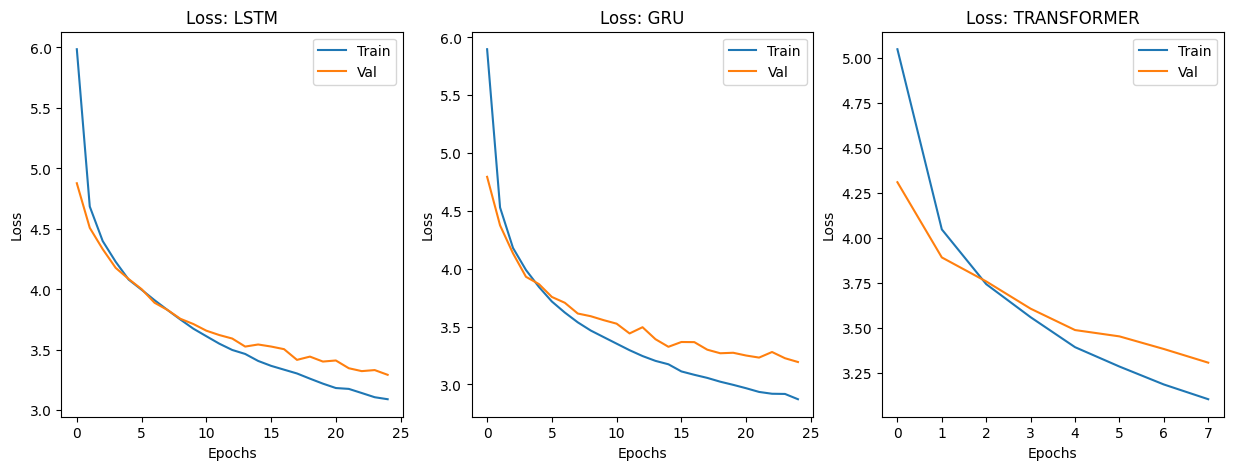

In [ ]:
with open(os.path.join(SAVE_DIR, 'metrics.json'), 'r') as f:
    results = json.load(f)

plt.figure(figsize=(15, 5))
for i, model_name in enumerate(results.keys()):
    plt.subplot(1, 3, i+1)
    plt.plot(results[model_name]['train_loss'], label='Train')
    plt.plot(results[model_name]['val_loss'], label='Val')
    plt.title(f'Loss: {model_name.upper()}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

#Teste visual dos resultados

Gerando legendas para imagens do conjunto de teste...

--- Modelo: LSTM ---


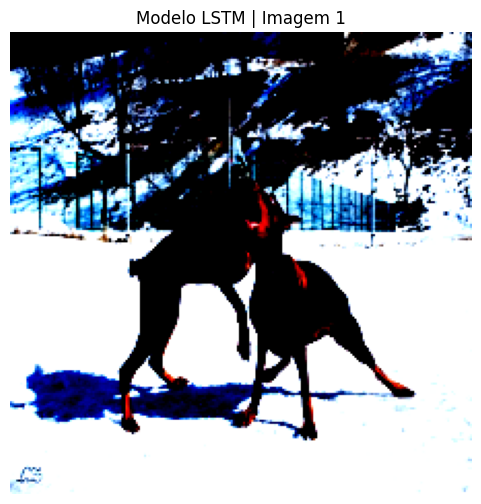

Legenda Gerada (Imagem 1): two dogs are running through the snow


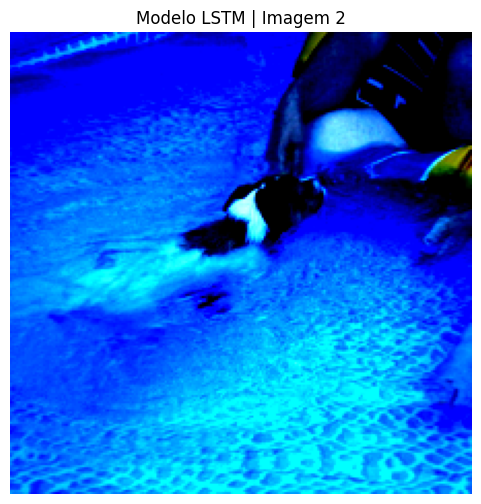

Legenda Gerada (Imagem 2): a white dog is jumping over a hurdle


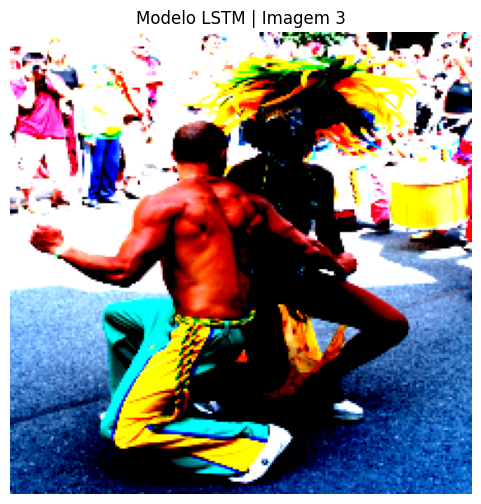

Legenda Gerada (Imagem 3): a man in a white shirt is standing in front of a building


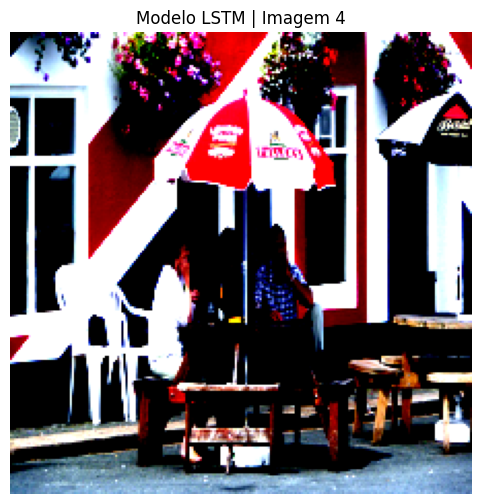

Legenda Gerada (Imagem 4): three people are sitting on a bench


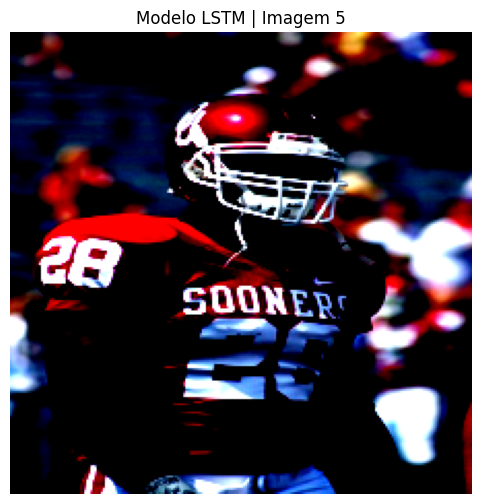

Legenda Gerada (Imagem 5): a football player in a white uniform is running


--- Modelo: GRU ---


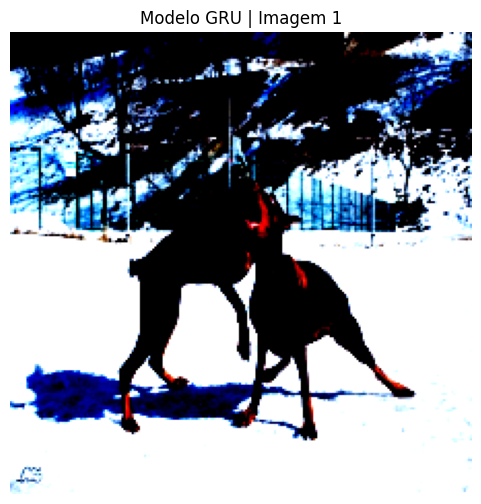

Legenda Gerada (Imagem 1): two dogs are running through the snow


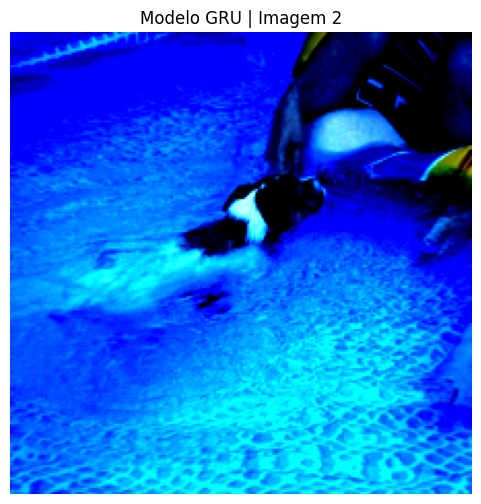

Legenda Gerada (Imagem 2): a white dog is jumping into the water


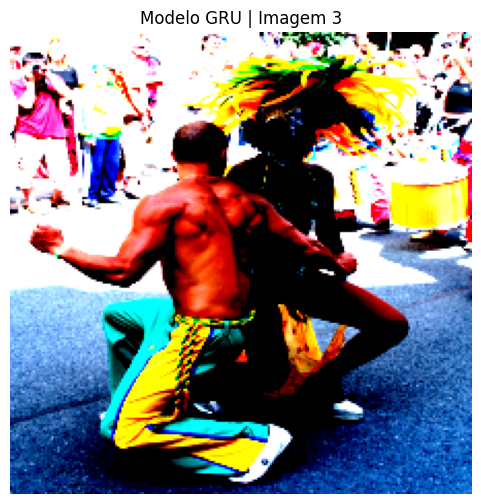

Legenda Gerada (Imagem 3): a man in a red shirt is standing in front of a building


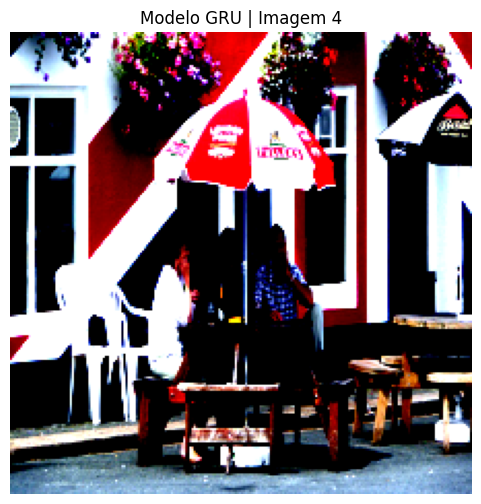

Legenda Gerada (Imagem 4): two women in front of a crowd


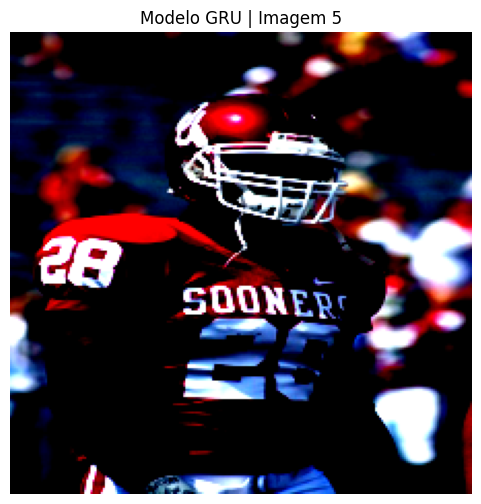

Legenda Gerada (Imagem 5): a football player in a red shirt


--- Modelo: TRANSFORMER ---


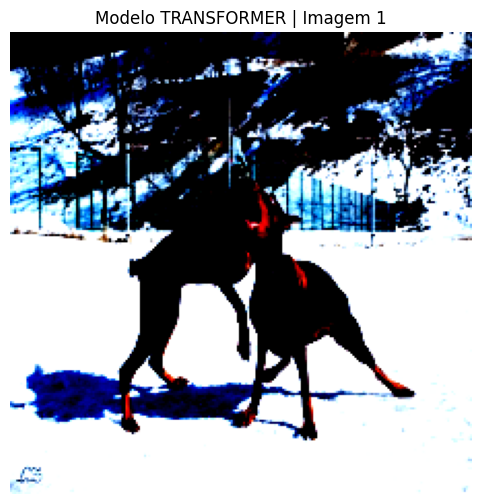

Legenda Gerada (Imagem 1): two brown dogs are playing in the snow


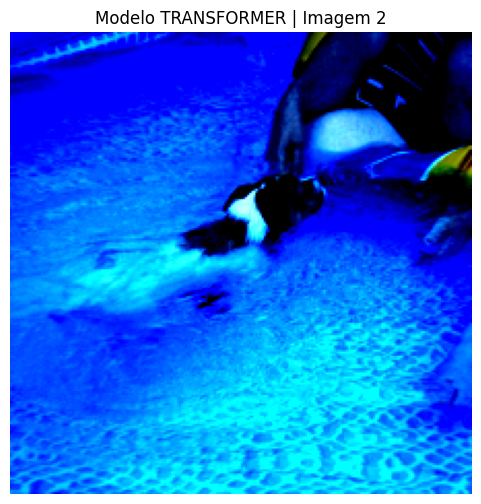

Legenda Gerada (Imagem 2): a dog is jumping into a blue pool


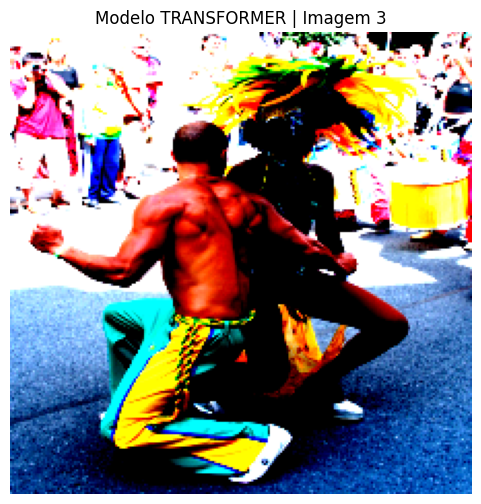

Legenda Gerada (Imagem 3): a man in a blue shirt is standing on a blue and blue shirt


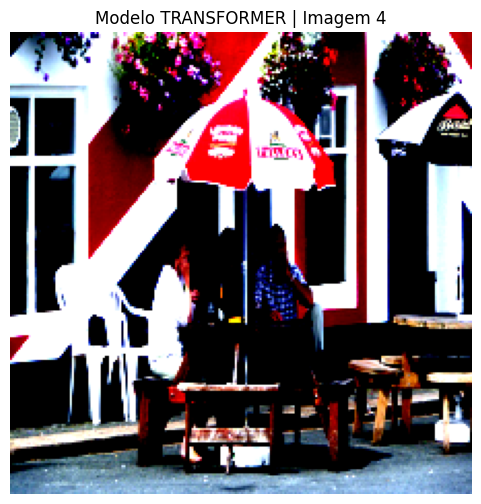

Legenda Gerada (Imagem 4): a man and a woman sitting on a bench


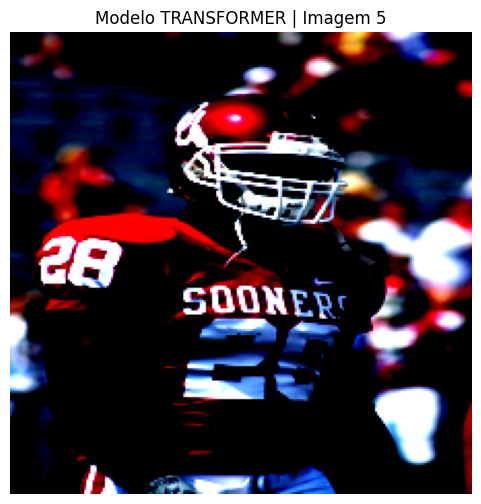

Legenda Gerada (Imagem 5): a football player in a red uniform is standing in a red and white jersey




In [ ]:


encoder.eval()

print("Gerando legendas para imagens do conjunto de teste...\n")

imgs, caps, _ = next(iter(test_loader))

for model_name in ['lstm', 'gru', 'transformer']:
    print(f"--- Modelo: {model_name.upper()} ---")

    if model_name == 'lstm':
        dec = DecoderLSTM(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE).to(device)
    elif model_name == 'gru':
        dec = DecoderGRU(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE).to(device)
    else:
        dec = DecoderTransformer(EMBED_SIZE, VOCAB_SIZE, 4, 1024, 2).to(device)

    path = os.path.join(SAVE_DIR, f'{model_name}_best.pth')
    if os.path.exists(path):
        dec.load_state_dict(torch.load(path, map_location=device))


    for i in range(5):
        img = imgs[i]
        caption_gen = generate_caption(encoder, dec, img, word2idx, idx2word)

        img_np = img.cpu().permute(1, 2, 0).numpy()

        if img_np.dtype == np.float32 or img_np.dtype == np.float64:
            img_np = np.clip(img_np, 0, 1)

        plt.figure(figsize=(6, 6))
        plt.imshow(img_np)
        plt.title(f"Modelo {model_name.upper()} | Imagem {i+1}")
        plt.xlabel(f"Legenda: {caption_gen}")
        plt.axis('off')
        plt.show()


        print(f"Legenda Gerada (Imagem {i+1}): {caption_gen}")

    print("\n")

#Resultado Final dos BLEU 1-4

In [ ]:
print("\n\n=== RESULTADOS DO BLEU NO TESTE ===")

FINAL_BLEU_RESULTS = {}

for model_name in ['lstm', 'gru', 'transformer']:
    print(f"\nAvaliando {model_name.upper()}...")

    if model_name == 'lstm':
        decoder = DecoderLSTM(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE).to(device)
    elif model_name == 'gru':
        decoder = DecoderGRU(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE).to(device)
    else:
        decoder = DecoderTransformer(embed_size=EMBED_SIZE, vocab_size=VOCAB_SIZE,
                                     num_heads=4, hidden_dim=1024, num_layers=2).to(device)

    path = os.path.join("checkpoints_all", f"{model_name}_best.pth")
    if os.path.exists(path):
        decoder.load_state_dict(torch.load(path, map_location=device))
    else:
        print("Pesos não encontrados. Pulando...")
        continue

    bleu_scores = calculate_bleu_all(
        encoder, decoder, val_loader,
        encoded_captions, word2idx, idx2word, device
    )

    FINAL_BLEU_RESULTS[model_name] = bleu_scores

    print(f"\nBLEU Scores para {model_name.upper()}:")
    print(f" - BLEU-1: {bleu_scores['bleu1'] * 100:.2f}%")
    print(f" - BLEU-2: {bleu_scores['bleu2'] * 100:.2f}%")
    print(f" - BLEU-3: {bleu_scores['bleu3'] * 100:.2f}%")
    print(f" - BLEU-4: {bleu_scores['bleu4'] * 100:.2f}%")

print("\nResultados finais:")
print(FINAL_BLEU_RESULTS)



=== RESULTADOS DO BLEU NO TESTE ===

Avaliando LSTM...


Calculando BLEU: 100%|██████████| 32/32 [00:16<00:00,  1.95it/s]



BLEU Scores para LSTM:
 - BLEU-1: 51.19%
 - BLEU-2: 32.65%
 - BLEU-3: 20.57%
 - BLEU-4: 13.18%

Avaliando GRU...


Calculando BLEU: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]



BLEU Scores para GRU:
 - BLEU-1: 53.01%
 - BLEU-2: 35.48%
 - BLEU-3: 23.32%
 - BLEU-4: 15.52%

Avaliando TRANSFORMER...


Calculando BLEU: 100%|██████████| 32/32 [00:38<00:00,  1.21s/it]



BLEU Scores para TRANSFORMER:
 - BLEU-1: 58.83%
 - BLEU-2: 40.81%
 - BLEU-3: 26.88%
 - BLEU-4: 17.49%

Resultados finais:
{'lstm': {'bleu1': 0.5118770003318787, 'bleu2': 0.3264673352241516, 'bleu3': 0.20572435855865479, 'bleu4': 0.1318380981683731}, 'gru': {'bleu1': 0.5301003456115723, 'bleu2': 0.3548180162906647, 'bleu3': 0.23320169746875763, 'bleu4': 0.1551751345396042}, 'transformer': {'bleu1': 0.588274359703064, 'bleu2': 0.40808936953544617, 'bleu3': 0.2687944769859314, 'bleu4': 0.17485767602920532}}


## 4. Conclusão

Este estudo conduziu uma análise comparativa aprofundada entre arquiteturas recorrentes (LSTM e GRU) e baseadas em atenção (Transformer) para a tarefa de Image Captioning, utilizando a ResNet50 como extrator de características visuais. Gerando uma implementação bem-sucedida, desde o pré-processamento do dataset Flickr8k até a avaliação com métricas BLEU, permitiu isolar as variáveis arquiteturais e compreender seus impactos na geração de linguagem natural a partir de estímulos visuais.

Além disso, a análise de desempenho corrobora o estado da arte atual. Conforme apontado no levantamento recente de Albadarneh, Hammo e Al-Kadi (2025), embora arquiteturas baseadas em atenção melhorem significativamente a compreensão da cena, elas não são isentas de custos. Os autores destacam que modelos Transformer convertem vetores visuais em sequências de palavras oferecendo trade-offs críticos entre complexidade computacional e eficiência, especialmente quando aplicados em datasets médios como o Flickr8k, onde a escassez de dados pode limitar a capacidade de generalização sem regularização extensiva.

Conclui-se que, embora as arquiteturas baseadas em Transformers encontraram as melhores métricas de processamento de texto, com muito menos treino, devido à sua capacidade de modelar dependências globais via Multi-Head Attention, sua aplicação em datasets de médio porte como o Flickr8k exige estratégias de regularização para evitar o overfitting. Em contrapartida, as redes recorrentes LSTM e GRU demonstraram-se baselines robustos e computacionalmente eficientes, oferecendo uma convergência estável e resultados competitivos em métricas de n-gramas inferiores, BLEU-1 e BLEU-2, validando sua utilidade em cenários com restrições de dados ou recursos de hardware.

A preservação da estrutura espacial das características da imagem na saída do codificador ResNet50 provou-se fundamental. Ao não colapsar essas dimensões em um vetor global único prematuramente, permitiu-se que o decodificador Transformer acessasse a "memória" visual de forma granular, associando palavras específicas a regiões distintas da imagem durante o processo de geração.

## 5. Referências

> LIU, H.; BRAILSFORD, T. Reproducing “Show, Attend and Tell: Neural Image Caption Generation with Visual Attention”. Journal of Physics: Conference Series, v. 2589, n. 1, p. 012012–012012, 1 set. 2023. Acesso em: 1 de dez. de 2025.

> JBROWnlee. Datasets. GitHub, 2025. Disponível em: https://github.com/jbrownlee/Datasets
. Acesso em: 03 dez. 2025.

> DARK_CODER88. Image Caption Generator using Deep Learning on Flickr8K dataset. GeeksforGeeks, 15 jul. 2025. Disponível em: https://www.geeksforgeeks.org/image-caption-generator-using-deep-learning-on-flickr8k-dataset/
. Acesso em: 03 dez. 2025.

> Attention-Based Transformer Models for Image Captioning Across Languages: An In-depth Survey and Evaluation. Disponível em: <https://arxiv.org/html/2506.05399v1>.
. Acesso em 03 dez. 2025.

‌
